In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Read data

In [3]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

# Prepare regression data

In [4]:
dfx = df.copy()
dfx = dfx.rename(columns={
    'aggregated': 'w2h',
    'electricity_from_gas': 'power',
    'producing_sector': 'econ',
    'gas_price [€/MWh]': 'prices'
})

dfx = dfx[
    (dfx.holiday==0) & 
    (dfx.christmas_period==0) & 
    (dfx.bridgeday==0)
]

In [5]:
high_gas_date = "2021-09-01"
covid_beginning = "2020-02-01"
invasion_date = "2022-02-24"

Monthly treatment dummies from Sep 2021 onwards:

In [6]:
dummy_list = []
for date in pd.date_range('2021-09', '2022-04', freq='1m'):
    dummy_name = f'd{date.year}_{date.month}'
    dfx.loc[dfx.index, dummy_name] = dfx.index.map(
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values
    dummy_list.append(dummy_name)

In [7]:
dfx

,slp,rlm,gas_to_electricity,power,prices,econ,residential,commercial,decentral_chp,industry_buildings,...,christmas_period,holiday,bridgeday,d2021_9,d2021_10,d2021_11,d2021_12,d2022_1,d2022_2,d2022_3
2017-01-02,2.362777,2.056043,0.549828,234.902217,NaN,91.7,1.423058,0.670494,0.102627,0.171044,...,0,0,0,False,False,False,False,False,False,False
2017-01-03,2.284347,2.030095,0.453608,193.794329,NaN,91.7,1.362677,0.635979,0.097344,0.162240,...,0,0,0,False,False,False,False,False,False,False
2017-01-04,2.203892,2.108759,0.465417,198.839085,NaN,91.7,1.305514,0.598531,0.091612,0.152686,...,0,0,0,False,False,False,False,False,False,False
2017-01-05,2.509253,2.358004,0.763463,326.173074,NaN,91.7,1.441746,0.680565,0.104168,0.173613,...,0,0,0,False,False,False,False,False,False,False
2017-01-07,2.758369,2.134451,0.553247,236.362591,NaN,91.7,1.691065,0.740020,0.113268,0.188781,...,0,0,0,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-21,1.392489,1.760465,0.571950,244.353213,96.302,106.9,0.795028,0.319985,0.048977,0.081629,...,0,0,0,False,False,False,False,False,False,True
2022-03-22,1.298477,1.775411,0.725432,309.925058,98.745,106.9,0.746694,0.293959,0.044994,0.074989,...,0,0,0,False,False,False,False,False,False,True
2022-03-23,1.192763,1.735938,0.749840,320.352790,117.000,106.9,0.704113,0.268936,0.041164,0.068606,...,0,0,0,False,False,False,False,False,False,True
2022-03-24,1.139401,1.730537,0.762009,325.551653,111.610,106.9,0.685957,0.261335,0.040000,0.066667,...,0,0,0,False,False,False,False,False,False,True


In [8]:
def extract_results(results, log=True):
    extracted_results = pd.concat(
        [results.params, results.bse], keys=['coef', 'se'], axis=1
    )
    extracted_results = extracted_results*100 if log else extracted_results
    extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
    extracted_results.index = dummy_list
    extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
    extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
    return extracted_results

# SLP regression
Log-linear model

In [9]:
dfx['log_slp'] = np.log(dfx['slp'])

model = 'log_slp ~ 1 + w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
results_slp_log = smf.ols(model, dfx).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_slp_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_slp   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     513.1
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:23:09   Log-Likelihood:                 765.89
No. Observations:                1764   AIC:                            -1478.
Df Residuals:                    1737   BIC:                            -1330.
Df Model:                          26                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.9628      0.076    -12.660      0.000      -1.112      -0.814
C(weekday)[T.Monday]       -0.0097      0.010     -1.009      0.313      -0.029       0.009
C(weekday)[T.Saturday]      0.0032      0.006      0.517      0.605      -0.009       0.016
C(weekday)[T.Sunday]        0.0021      0.008      0.244      0.807      -0.015       0.019
C(weekday)[T.Thursday]     -0.0033      0.007     -0.477      0.633      -0.017       0.010
C(weekday)[T.Tuesday]      -0.0029      0.010     -0.296      0.767      -0.022       0.016
C(weekday)[T.Wednesday]    -0.0035      0.009     -0.398      0.691      -0.021       0.014
C(month)[T.2]               0.0377      0.036      1.049      0.294      -0.033       0.108
C(month)[T.3]               0.0881      0.036      2.441      0.015       0.017       0.159
C(month)[T.4]               0.0081      0.045      0.181      0.856      -0.080       0.096
C(month)[T.5]              -0.2055      0.065     -3.141      0.002      -0.334      -0.077
C(month)[T.6]              -0.6828      0.074     -9.280      0.000      -0.827      -0.539
C(month)[T.7]              -0.7443      0.073    -10.210      0.000      -0.887      -0.601
C(month)[T.8]              -0.7613      0.075    -10.150      0.000      -0.908      -0.614
C(month)[T.9]              -0.3525      0.071     -4.934      0.000      -0.493      -0.212
C(month)[T.10]             -0.0465      0.048     -0.968      0.333      -0.141       0.048
C(month)[T.11]              0.0459      0.032      1.448      0.148      -0.016       0.108
C(month)[T.12]              0.0428      0.029      1.460      0.144      -0.015       0.100
d2021_9[T.True]            -0.0752      0.082     -0.916      0.360      -0.236       0.086
d2021_10[T.True]            0.0752      0.038      1.956      0.050      -0.000       0.150
d2021_11[T.True]            0.0623      0.027      2.274      0.023       0.009       0.116
d2021_12[T.True]            0.0093      0.041      0.226      0.821      -0.072       0.090
d2022_1[T.True]             0.0886      0.036      2.437      0.015       0.017       0.160
d2022_2[T.True]             0.1243      0.035      3.542      0.000       0.056       0.193
d2022_3[T.True]            -0.0180      0.035     -0.511      0.609      -0.087       0.051
w2h                         0.7874      0.035     22.278      0.000       0.718       0.857
time                     9.693e-05   1.85e-05      5.234      0.000    6.06e-05       0.000
==============================================================================
Omnibus:                      144.405   Durbin-Watson:                   0.222
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              238.021
Skew:                          -0.599   Prob(JB):                     2.06e-52
Kurtosi

(-30.0, 15.0)

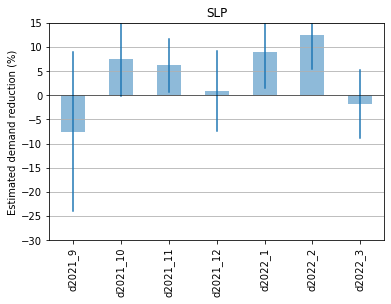

In [10]:
extracted_results = extract_results(results_slp_log)
ax = extracted_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.title('SLP')
plt.ylim(-30, 15)

Linear model

In [11]:
model = 'slp ~ 1 + w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
results_slp = smf.ols(model, dfx).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_slp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    slp   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     5307.
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:23:10   Log-Likelihood:                 2028.4
No. Observations:                1764   AIC:                            -4003.
Df Residuals:                    1737   BIC:                            -3855.
Df Model:                          26                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1498      0.045      3.310      0.001       0.061       0.239
C(weekday)[T.Monday]       -0.0062      0.004     -1.505      0.132      -0.014       0.002
C(weekday)[T.Saturday]      0.0023      0.003      0.795      0.426      -0.003       0.008
C(weekday)[T.Sunday]        0.0039      0.004      1.044      0.297      -0.003       0.011
C(weekday)[T.Thursday]     -0.0027      0.003     -0.884      0.377      -0.009       0.003
C(weekday)[T.Tuesday]      -0.0059      0.005     -1.316      0.188      -0.015       0.003
C(weekday)[T.Wednesday]    -0.0064      0.004     -1.631      0.103      -0.014       0.001
C(month)[T.2]              -0.0048      0.040     -0.119      0.905      -0.083       0.074
C(month)[T.3]              -0.0690      0.036     -1.901      0.057      -0.140       0.002
C(month)[T.4]              -0.1417      0.038     -3.714      0.000      -0.216      -0.067
C(month)[T.5]              -0.1870      0.040     -4.677      0.000      -0.265      -0.109
C(month)[T.6]              -0.1874      0.042     -4.448      0.000      -0.270      -0.105
C(month)[T.7]              -0.1920      0.042     -4.552      0.000      -0.275      -0.109
C(month)[T.8]              -0.1968      0.042     -4.665      0.000      -0.280      -0.114
C(month)[T.9]              -0.2098      0.041     -5.160      0.000      -0.289      -0.130
C(month)[T.10]             -0.1824      0.037     -4.896      0.000      -0.255      -0.109
C(month)[T.11]             -0.1359      0.034     -4.051      0.000      -0.202      -0.070
C(month)[T.12]             -0.0569      0.034     -1.676      0.094      -0.123       0.010
d2021_9[T.True]             0.0207      0.016      1.283      0.200      -0.011       0.052
d2021_10[T.True]            0.0564      0.023      2.505      0.012       0.012       0.100
d2021_11[T.True]            0.1489      0.027      5.444      0.000       0.095       0.203
d2021_12[T.True]            0.1360      0.030      4.583      0.000       0.078       0.194
d2022_1[T.True]             0.1282      0.038      3.417      0.001       0.055       0.202
d2022_2[T.True]             0.1244      0.033      3.805      0.000       0.060       0.188
d2022_3[T.True]             0.0624      0.036      1.726      0.084      -0.008       0.133
w2h                         0.9460      0.015     62.723      0.000       0.916       0.976
time                     5.041e-05   1.17e-05      4.323      0.000    2.76e-05    7.33e-05
==============================================================================
Omnibus:                      286.869   Durbin-Watson:                   0.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              989.862
Skew:                           0.786   Prob(JB):                    1.13e-215
Kurtosi

(-0.15, 0.1)

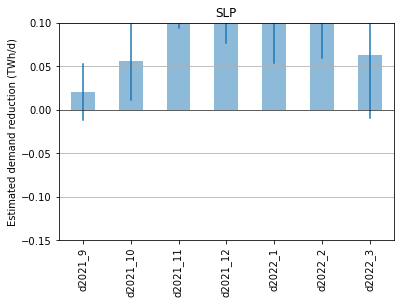

In [12]:
extracted_results = extract_results(results_slp, log=False)
ax = extracted_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (TWh/d)')
plt.title('SLP')
plt.ylim(-0.15, 0.1)

# RLM
Loglinear model

In [13]:
dfx['log_rlm'] = np.log(dfx['rlm'])

results_rlm_log = {}
for m in ['temp', 'temp+power', 'temp+power+econ']:
    model = 'log_rlm ~ 1 + w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
    if 'power' in m:
        model += ' + power'
    if 'econ' in m:
        model += ' + econ'
    results_rlm_log[m] = smf.ols(model, dfx).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_rlm_log['temp'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_rlm   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     561.8
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:23:11   Log-Likelihood:                 2589.4
No. Observations:                1764   AIC:                            -5125.
Df Residuals:                    1737   BIC:                            -4977.
Df Model:                          26                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.2813      0.019     14.437      0.000       0.243       0.319
C(weekday)[T.Monday]        0.0322      0.004      8.839      0.000       0.025       0.039
C(weekday)[T.Saturday]     -0.1604      0.003    -48.327      0.000      -0.167      -0.154
C(weekday)[T.Sunday]       -0.1627      0.004    -43.275      0.000      -0.170      -0.155
C(weekday)[T.Thursday]      0.0399      0.003     12.549      0.000       0.034       0.046
C(weekday)[T.Tuesday]       0.0427      0.004     11.023      0.000       0.035       0.050
C(weekday)[T.Wednesday]     0.0419      0.004     11.373      0.000       0.035       0.049
C(month)[T.2]              -0.0135      0.012     -1.135      0.256      -0.037       0.010
C(month)[T.3]              -0.0543      0.015     -3.524      0.000      -0.084      -0.024
C(month)[T.4]              -0.1044      0.018     -5.809      0.000      -0.140      -0.069
C(month)[T.5]              -0.1216      0.016     -7.616      0.000      -0.153      -0.090
C(month)[T.6]              -0.1036      0.017     -5.922      0.000      -0.138      -0.069
C(month)[T.7]              -0.1032      0.019     -5.479      0.000      -0.140      -0.066
C(month)[T.8]              -0.1356      0.020     -6.728      0.000      -0.175      -0.096
C(month)[T.9]              -0.0704      0.018     -3.832      0.000      -0.106      -0.034
C(month)[T.10]             -0.0181      0.015     -1.193      0.233      -0.048       0.012
C(month)[T.11]             -0.0003      0.012     -0.028      0.978      -0.023       0.022
C(month)[T.12]             -0.0175      0.012     -1.398      0.162      -0.042       0.007
d2021_9[T.True]            -0.0894      0.014     -6.543      0.000      -0.116      -0.063
d2021_10[T.True]           -0.1103      0.013     -8.490      0.000      -0.136      -0.085
d2021_11[T.True]           -0.0116      0.012     -0.942      0.346      -0.036       0.013
d2021_12[T.True]            0.0113      0.023      0.486      0.627      -0.034       0.057
d2022_1[T.True]            -0.0251      0.020     -1.233      0.218      -0.065       0.015
d2022_2[T.True]            -0.0518      0.012     -4.437      0.000      -0.075      -0.029
d2022_3[T.True]            -0.0385      0.018     -2.102      0.036      -0.074      -0.003
w2h                         0.2198      0.008     28.612      0.000       0.205       0.235
time                     2.821e-05   6.51e-06      4.333      0.000    1.54e-05     4.1e-05
==============================================================================
Omnibus:                       96.620   Durbin-Watson:                   0.554
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.780
Skew:                          -0.473   Prob(JB):                     1.63e-31
Kurtosi

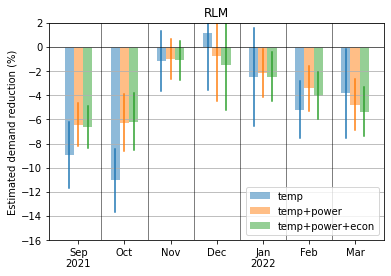

In [14]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i, m in enumerate(['temp', 'temp+power', 'temp+power+econ']):
    
    extracted_results = extract_results(results_rlm_log[m])
    
    idx = [j-0.2+0.2*i for j in range(len(extracted_results))]
    plt.bar(idx, extracted_results['coef'], width=0.2,alpha=0.5, label=m)
    for j, d in enumerate(dummy_list):
        plt.plot([idx[j],idx[j]], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], 
                 color=colors[i])
        
for i in range(len(extracted_results)-1):
    plt.axvline(i+0.5, color='black', linewidth=0.5)

plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.title('RLM')
plt.ylim(-16, 2)
plt.xticks(range(len(extracted_results)), 
           [f'{date.month_name()[:3]}'+(
               '\n2021' if date.month==9 else (
                   '\n2022' if date.month==1 else ''
               )
           ) for date in pd.date_range('2021-09', '2022-04', freq='1m')])    
plt.legend(loc='lower right')
plt.savefig('rlm_log.png', dpi=300)

In [15]:
dfx['log_rlm'] = np.log(dfx['rlm'])

results_rlm = {}
for m in ['temp', 'temp+power', 'temp+power+econ']:
    model = 'rlm ~ 1 + w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
    if 'power' in m:
        model += ' + power'
    if 'econ' in m:
        model += ' + econ'
    results_rlm[m] = smf.ols(model, dfx).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_rlm['temp'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rlm   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     521.8
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:23:13   Log-Likelihood:                 1721.2
No. Observations:                1764   AIC:                            -3388.
Df Residuals:                    1737   BIC:                            -3241.
Df Model:                          26                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.2831      0.039     33.120      0.000       1.207       1.359
C(weekday)[T.Monday]        0.0538      0.006      8.517      0.000       0.041       0.066
C(weekday)[T.Saturday]     -0.2368      0.005    -50.124      0.000      -0.246      -0.228
C(weekday)[T.Sunday]       -0.2400      0.006    -43.118      0.000      -0.251      -0.229
C(weekday)[T.Thursday]      0.0648      0.005     11.919      0.000       0.054       0.075
C(weekday)[T.Tuesday]       0.0682      0.007     10.045      0.000       0.055       0.082
C(weekday)[T.Wednesday]     0.0670      0.007     10.265      0.000       0.054       0.080
C(month)[T.2]              -0.0307      0.027     -1.137      0.255      -0.084       0.022
C(month)[T.3]              -0.1191      0.030     -3.960      0.000      -0.178      -0.060
C(month)[T.4]              -0.1792      0.033     -5.502      0.000      -0.243      -0.115
C(month)[T.5]              -0.1796      0.031     -5.886      0.000      -0.239      -0.120
C(month)[T.6]              -0.1169      0.033     -3.500      0.000      -0.182      -0.051
C(month)[T.7]              -0.1161      0.034     -3.377      0.001      -0.183      -0.049
C(month)[T.8]              -0.1591      0.036     -4.427      0.000      -0.230      -0.089
C(month)[T.9]              -0.0961      0.034     -2.854      0.004      -0.162      -0.030
C(month)[T.10]             -0.0441      0.030     -1.469      0.142      -0.103       0.015
C(month)[T.11]             -0.0198      0.024     -0.814      0.415      -0.068       0.028
C(month)[T.12]             -0.0459      0.026     -1.775      0.076      -0.097       0.005
d2021_9[T.True]            -0.1138      0.021     -5.340      0.000      -0.156      -0.072
d2021_10[T.True]           -0.1744      0.020     -8.754      0.000      -0.213      -0.135
d2021_11[T.True]           -0.0160      0.022     -0.721      0.471      -0.060       0.028
d2021_12[T.True]            0.0282      0.040      0.707      0.480      -0.050       0.106
d2022_1[T.True]            -0.0539      0.039     -1.375      0.169      -0.131       0.023
d2022_2[T.True]            -0.1095      0.024     -4.576      0.000      -0.156      -0.063
d2022_3[T.True]            -0.0606      0.034     -1.798      0.072      -0.127       0.005
w2h                         0.3934      0.015     26.382      0.000       0.364       0.423
time                     4.343e-05   1.08e-05      4.028      0.000    2.23e-05    6.46e-05
==============================================================================
Omnibus:                      116.698   Durbin-Watson:                   0.511
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.551
Skew:                          -0.389   Prob(JB):                     1.98e-61
Kurtosi

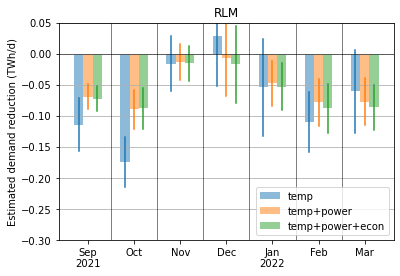

In [16]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i, m in enumerate(['temp', 'temp+power', 'temp+power+econ']):
    
    extracted_results = extract_results(results_rlm[m], log=False)
    
    idx = [j-0.2+0.2*i for j in range(len(extracted_results))]
    plt.bar(idx, extracted_results['coef'], width=0.2,alpha=0.5, label=m)
    for j, d in enumerate(dummy_list):
        plt.plot([idx[j],idx[j]], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], 
                 color=colors[i])
        
for i in range(len(extracted_results)-1):
    plt.axvline(i+0.5, color='black', linewidth=0.5)

plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (TWh/d)')
plt.title('RLM')
plt.ylim(-0.3, 0.05)
plt.xticks(range(len(extracted_results)), 
           [f'{date.month_name()[:3]}'+(
               '\n2021' if date.month==9 else (
                   '\n2022' if date.month==1 else ''
               )
           ) for date in pd.date_range('2021-09', '2022-04', freq='1m')])    
plt.legend(loc='lower right')
plt.savefig('rlm.png', dpi=300)

# Disaggregation based on fundamental assumption / energy balances

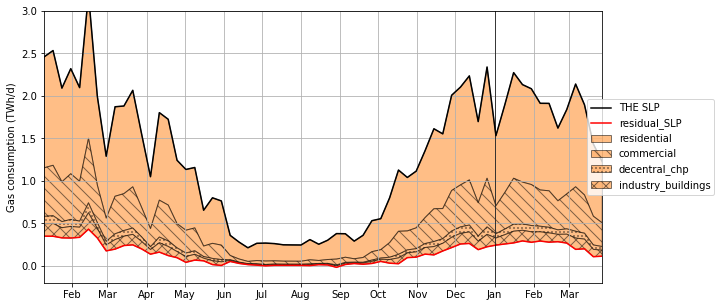

In [17]:
plt.figure(figsize=(10,5))

#weekly
dft = df.resample("1w").mean().dropna()
plt.xlim(dft.index[[0, -1]])

upper=dft['slp']
plt.plot(dft.index, dft['slp'], label='THE SLP', color="k")

for sector, h in [
    ("residential", ""), 
    ("commercial",  "\\\\"), 
    ("decentral_chp", "..."),
    ("industry_buildings", "XX")
]:
    plt.fill_between(
        dft.index, upper-dft[sector], upper, label=sector,
        color="tab:orange", hatch=h, edgecolor="k", alpha=0.5)
    upper = upper-dft[sector]

plt.plot(upper.index, upper, color="red", label="residual_SLP")

plt.ylim(-0.2, 3)
plt.axvline(pd.Timestamp('2022-01-01'), color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.21, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))

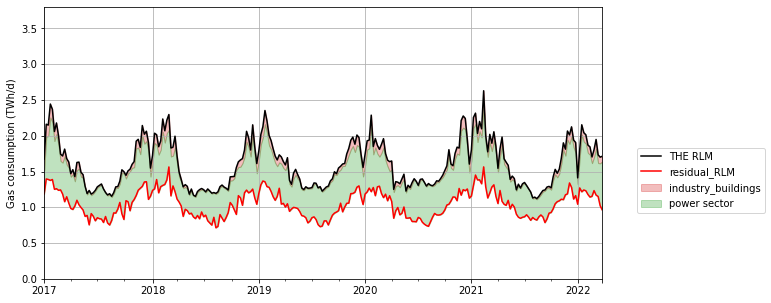

In [18]:
plt.figure(figsize=(10,5))

dft= df.resample("1w").mean()
the_rlm = dft['rlm']
the_rlm.plot(label='THE RLM', color="k")

power_res = the_rlm - dft['gas_to_electricity']
industry = dft["industry_buildings"]

upper=the_rlm
for sector, c, label in [
    (industry,"tab:red","industry_buildings"), 
    (dft['gas_to_electricity'],  "tab:green", "power sector")
    # (dft["scaled_district_heat"], "tab:orange", "dist_heat")
]: 
    plt.fill_between(dft.index, upper-sector, upper , color="{}".format(c), alpha=0.3, label=label)
    upper = upper-sector 

upper.plot(color="red", label="residual_RLM")

plt.xlim(power_res.dropna().index[[0, -1]])
plt.ylim(0, 3.8)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

plt.show()

In [19]:
df_x_no_holiday = dfx[(dfx.holiday==0) & (dfx.christmas_period==0) & (dfx.bridgeday==0)]

In [20]:
#SLP
model_the_slp = smf.ols(
    'slp ~ 1 + w2h + C(weekday) + C(month)', 
    data=dfx.loc[(dfx.index <= high_gas_date)&(dfx.index >= '2016-10-01')]
)
results_the_slp = model_the_slp.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 
#results_the_slp.summary()



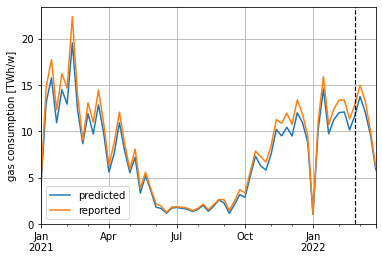

Text(0, 0.5, 'regression delta [TWh/w]')

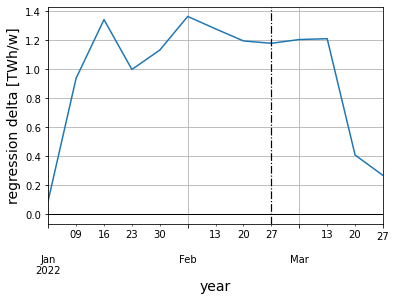

In [21]:
the_slp_prediction = results_the_slp.predict(df_x_no_holiday[df_x_no_holiday.index.year>=2021])
the_slp_prediction.name = "the_slp_forecast"

the_slp_combined = pd.concat([
    the_slp_prediction, df_x_no_holiday.loc[df_x_no_holiday.index.year>=2021]["slp"]
], axis=1, keys=["predicted", "reported"])

the_slp_combined.resample("1w").sum().plot(ylim=0).set_ylabel("gas consumption [TWh/w]")
plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2)
plt.grid() 


plt.show()

delta_the_slp = the_slp_combined.iloc[:,1]-the_slp_combined.iloc[:,0]

ax = delta_the_slp.loc[delta_the_slp.index.year==2022].resample("w").sum().plot()
ax.axvline(x=invasion_date, color='k', linestyle='-.', lw=1.2 )
ax.axhline(y=0, color='k', lw=1)
plt.grid()
ax.set_xlabel("year",fontsize=14)
ax.set_ylabel("regression delta [TWh/w]", fontsize=14)




In [22]:
mean_rlm_the = df_x_no_holiday['rlm'].mean()

normalized_results = extracted_results/mean_rlm_the*100

#calculate normalized results by division by mean of rlm_the across entire sample (without log transformation, using original rlm_the)

model = 'rlm ~ 1 + w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
results = smf.ols(model, df_x_no_holiday).fit(cov_type='HAC', cov_kwds={'maxlags':6})

extracted_results = pd.concat(
    [results.params, results.HC0_se], keys=['coef', 'se'], axis=1
)
extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
extracted_results.index = dummy_list
extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
extracted_results

,coef,se,low,high
d2021_9,-0.113788,0.011891,-0.137570,-0.090006
d2021_10,-0.174416,0.012750,-0.199916,-0.148915
d2021_11,-0.016019,0.019394,-0.054806,0.022768
d2021_12,0.028223,0.031947,-0.035672,0.092117
d2022_1,-0.053934,0.025311,-0.104557,-0.003312
d2022_2,-0.109481,0.014492,-0.138464,-0.080497
d2022_3,-0.060562,0.019972,-0.100505,-0.020618


(-40.0, 2.0)

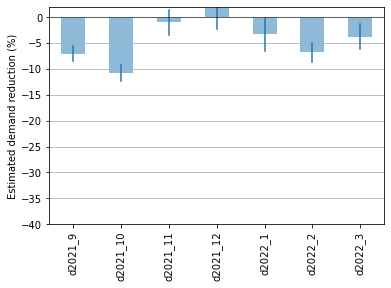

In [23]:
mean_rlm_the = df_x_no_holiday['rlm'].mean()

normalized_results = extracted_results/mean_rlm_the*100

ax = normalized_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [normalized_results.loc[d, 'low'], normalized_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.ylim(-40, 2)
#plt.xticklabels()

## linear model

In [24]:
df = pd.DataFrame(range(1,6))
df['sq'] = df[0].map(lambda x: x**2)
df

,0,sq
0,1,1
1,2,4
2,3,9
3,4,16
4,5,25


In [25]:
model = 'rlm ~ 1 + w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
results = smf.ols(model, df_x_no_holiday).fit(cov_type='HAC', cov_kwds={'maxlags':6})

In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rlm   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     521.8
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:23:18   Log-Likelihood:                 1721.2
No. Observations:                1764   AIC:                            -3388.
Df Residuals:                    1737   BIC:                            -3241.
Df Model:                          26                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.2831      0.039     33.120      0.000       1.207       1.359
C(weekday)[T.Monday]        0.0538      0.006      8.517      0.000       0.041       0.066
C(weekday)[T.Saturday]     -0.2368      0.005    -50.124      0.000      -0.246      -0.228
C(weekday)[T.Sunday]       -0.2400      0.006    -43.118      0.000      -0.251      -0.229
C(weekday)[T.Thursday]      0.0648      0.005     11.919      0.000       0.054       0.075
C(weekday)[T.Tuesday]       0.0682      0.007     10.045      0.000       0.055       0.082
C(weekday)[T.Wednesday]     0.0670      0.007     10.265      0.000       0.054       0.080
C(month)[T.2]              -0.0307      0.027     -1.137      0.255      -0.084       0.022
C(month)[T.3]              -0.1191      0.030     -3.960      0.000      -0.178      -0.060
C(month)[T.4]              -0.1792      0.033     -5.502      0.000      -0.243      -0.115
C(month)[T.5]              -0.1796      0.031     -5.886      0.000      -0.239      -0.120
C(month)[T.6]              -0.1169      0.033     -3.500      0.000      -0.182      -0.051
C(month)[T.7]              -0.1161      0.034     -3.377      0.001      -0.183      -0.049
C(month)[T.8]              -0.1591      0.036     -4.427      0.000      -0.230      -0.089
C(month)[T.9]              -0.0961      0.034     -2.854      0.004      -0.162      -0.030
C(month)[T.10]             -0.0441      0.030     -1.469      0.142      -0.103       0.015
C(month)[T.11]             -0.0198      0.024     -0.814      0.415      -0.068       0.028
C(month)[T.12]             -0.0459      0.026     -1.775      0.076      -0.097       0.005
d2021_9[T.True]            -0.1138      0.021     -5.340      0.000      -0.156      -0.072
d2021_10[T.True]           -0.1744      0.020     -8.754      0.000      -0.213      -0.135
d2021_11[T.True]           -0.0160      0.022     -0.721      0.471      -0.060       0.028
d2021_12[T.True]            0.0282      0.040      0.707      0.480      -0.050       0.106
d2022_1[T.True]            -0.0539      0.039     -1.375      0.169      -0.131       0.023
d2022_2[T.True]            -0.1095      0.024     -4.576      0.000      -0.156      -0.063
d2022_3[T.True]            -0.0606      0.034     -1.798      0.072      -0.127       0.005
w2h                         0.3934      0.015     26.382      0.000       0.364       0.423
time                     4.343e-05   1.08e-05      4.028      0.000    2.23e-05    6.46e-05
==============================================================================
Omnibus:                      116.698   Durbin-Watson:                   0.511
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.551
Skew:                          -0.389   Prob(JB):                     1.98e-61
Kurtosi

In [27]:
extracted_results = pd.concat(
    [results.params, results.HC0_se], keys=['coef', 'se'], axis=1
)
extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
extracted_results.index = dummy_list
extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
extracted_results

,coef,se,low,high
d2021_9,-0.113788,0.011891,-0.137570,-0.090006
d2021_10,-0.174416,0.012750,-0.199916,-0.148915
d2021_11,-0.016019,0.019394,-0.054806,0.022768
d2021_12,0.028223,0.031947,-0.035672,0.092117
d2022_1,-0.053934,0.025311,-0.104557,-0.003312
d2022_2,-0.109481,0.014492,-0.138464,-0.080497
d2022_3,-0.060562,0.019972,-0.100505,-0.020618


(-0.6, 0.05)

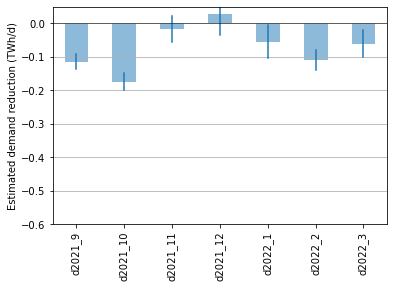

In [28]:
ax = extracted_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (TWh/d)')
plt.ylim(-0.6, 0.05)

# Regression variations

## Prices

In [29]:
model_the_prices = smf.ols('rlm ~ 1 + prices + w2h + power + econ + C(weekday)', 
                            data=df_x_no_holiday)
results_the_prices = model_the_prices.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 
#results_the_prices.summary()

## Dummies

In [30]:
dummy = pd.concat([
    pd.Series(1, index=df_x_no_holiday.index[df_x_no_holiday.index>=high_gas_date]),
    pd.Series(0, index=df_x_no_holiday.index[df_x_no_holiday.index<high_gas_date])
])

df_x_no_holiday["D"] = dummy

In [31]:
result_dict = {
    "only_slp": {},
    "no_econ": {},
    "all": {}
}

#2020/09-2021/08 (before high gas prices)

model_rdd_only_slp = smf.ols('rlm ~ 1 +  D + w2h + C(weekday)', data=df_x_no_holiday)
results_rdd_only_slp = model_rdd_only_slp.fit(cov_type='HAC', cov_kwds={'maxlags':6})

model_rdd_no_econ = smf.ols('rlm ~ 1 + D+ w2h + power + C(weekday)', data=df_x_no_holiday)
results_rdd_no_econ = model_rdd_no_econ.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 

 
model_rdd_all = smf.ols('rlm ~ 1 + D+ w2h + power + econ + C(weekday)', data=df_x_no_holiday)
results_rdd_all = model_rdd_all.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 

Text(0, 0.5, 'estimated reduction [%]')

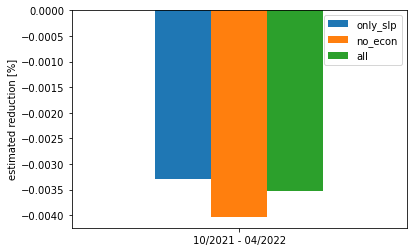

In [32]:
ax = pd.DataFrame(
    data=np.array([
    (results_rdd_all.params.D, results_rdd_no_econ.params.D,  results_rdd_only_slp.params.D), 
    ]), index=["10/2021 - 04/2022"], columns=["only_slp", "no_econ", "all"]
).plot(kind="bar", rot=0)
             
ax.set_ylabel("estimated reduction [%]")

In [33]:
dummy_coefficients = pd.DataFrame(columns=["dummy_coefficients", "P_value"])

for date in pd.date_range("2020-01-01", "2022-03-01", freq="M"):
    
    dummy = pd.concat([
        pd.Series(0,index=df_x_no_holiday.index[df_x_no_holiday.index<date.strftime('%Y-%m-%d')]),
        pd.Series(1,index=df_x_no_holiday.index[df_x_no_holiday.index>=date.strftime('%Y-%m-%d')]),
    ])
    
    df_x_no_holiday["dummy"] = dummy
    
    model = 'rlm ~ 1 + dummy + w2h + time + power + econ + C(weekday)'
    results = smf.ols(model, df_x_no_holiday).fit(cov_type='HAC', cov_kwds={'maxlags':6})
    
    dummy_coefficients.loc[date.strftime('%Y-%m-%d'), "dummy_coefficients"] = results.params.dummy
    dummy_coefficients.loc[date.strftime('%Y-%m-%d'), "P_value"] = pd.read_html(results.summary().tables[1].as_html(),header=0,index_col=0)[0].loc["dummy"]["P>|t|"]

KeyError: 'P>|t|'

In [ ]:
dummy_coefficients.plot()
plt.grid()

### Fitting period variation

In [ ]:
#2020/09-2021/08 (before high gas prices)
model_the_20_09 = smf.ols('rlm ~ 1 + w2h + power + econ + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-09-01')])
results_the_20_09 = model_the_20_09.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 

model_the_16_10 = smf.ols('rlm ~ 1 + w2h + power + econ + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <=  high_gas_date)&(df_x_no_holiday.index >= '2016-10-01')])
results_the_16_10 = model_the_16_10.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 

result_list = [
    (results_the_20_09,"fitting period: 2020/09 - 2021/08", '2020-09-01', high_gas_date),
    (results_the_16_10,"fitting period: 2016/10 - 2021/08", '2016-10-01', high_gas_date)
]

#results_the_20_09.summary()
#results_the_16_10.summary()

### Controlvariable variation

In [ ]:
#2020/09-2021/08 (before high gas prices)
result_list_2016 = []
for model_name in ["only_slp", "no_econ", "all"]:
    
    model = smf.ols(
        'rlm ~ 1 + w2h + C(weekday)' 
        + ('+ power' if model_name != 'only_slp' else '')
        + ('+ econ' if model_name == 'all' else '')
        , data=df_x_no_holiday.loc[
        (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-10-01')]
    )
    results = model.fit() 

    result_list_2016.append((results, model_name))

In [ ]:
def prediction(df, name, start_pred, rlm=True):
    delta = pd.DataFrame()
    key_list = ["reported"]

    if rlm == True:
        rlm_slp = "rlm"
    else: 
        rlm_slp = "slp"
        
    df_pred = df.predict(df_x_no_holiday[df_x_no_holiday.index>=start_pred])
    
    df_pred.name = f"{name}_forecast"

    combined = pd.concat([
        df_pred, df_x_no_holiday.loc[df_x_no_holiday.index>=start_pred][rlm_slp]
    ], axis=1, keys=[name, "reported"])
    print(combined.loc[(combined.index >=start_pred)].mean())
    ts = (combined.iloc[:,1]-combined.iloc[:,0])
    ts.name = name 
    delta = pd.concat([delta, ts], axis=1)
    
    return combined, delta, key_list

In [ ]:
result_dict = {
    "only_slp": {},
    "no_econ": {},
    "all": {}
}

expected_amount = df_x_no_holiday.loc[df_x_no_holiday.index>=high_gas_date]["rlm"].sum()

In [ ]:
start_pred = high_gas_date

for df, name in result_list_2016:
    
    combined, delta, key_list = prediction(df, name, start_pred)
    
    result_dict[name] = (
        delta[name][delta[name].index <= high_gas_date].sum() / expected_amount
    )

In [ ]:
ax = (pd.DataFrame.from_dict(result_dict, orient="index").transpose()*100).plot(kind = "bar", rot=45, xticks=[])
ax.set_ylabel("estimated reduction [%]")



In [ ]:
for df, name, start_pred, end_pred in result_list:
    
    combined, delta, key_list = prediction(df, name, start_pred)
    
    ax = combined.loc["2020-09-01":].resample("1w").sum().plot(ylim=0, xlim=("2020-09-01", "2022-04-30"), title = name)
    ax.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2 )
    ax.axvline(x="2021-08-31", color='k', linestyle='-.', lw=1.2 )
    
    ax.text((pd.to_datetime(high_gas_date)-pd.Timedelta(18, "days")).strftime('%Y-%m-%d'), 0.8, "gas prices" +"\n"+"\n" + "> 50€/MWh", size=10, rotation=90)
    ax.text((pd.to_datetime(invasion_date)-pd.Timedelta(30, "days")).strftime('%Y-%m-%d'), 0.8, "gas prices > 100€/MWh" + "\n" +"\n" + "invasion of Ukraine", size=10, rotation=90)
    
    fit = ax.text(
        (pd.to_datetime(high_gas_date)-pd.Timedelta(6, "days")).strftime('%Y-%m-%d'), 15, "fitting", ha="right", va="top", rotation=0, size=10,
        bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=2))
    forecast = ax.text(
        (pd.to_datetime(high_gas_date)+pd.Timedelta(6, "days")).strftime('%Y-%m-%d'), 14, "forecast", ha="left", va="top", rotation=0, size=10,
        bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=2))
    
    plt.grid()
    ax.set_ylabel("gas consumption [TWh/week]")
    ax.legend(loc='upper right', bbox_to_anchor=(1.65, 0.6))
    
    plt.show()
    
    key_list.append(name)
    

In [ ]:
delta.index = combined.index
delta_rlm = delta.dropna()

Q1_delta_rlm = delta_rlm["2022-02-24":].sum(0)

percent = Q1_delta_rlm / combined.loc["2022-02-24":,"reported"].sum(0)*100

weekly_rlm = Q1_delta_rlm / len(delta_rlm["2022-02-24":].index) * 7

print(
    "since war [TWh]:"+ "\n"+ str(Q1_delta_rlm) + "\n" + "\n" +
    "since war [%]:" + "\n"+ str(percent) + "\n" + "\n" +
    "weekly [TWh]:" + "\n"+ str(weekly_rlm)
     )

In [ ]:
resampled = delta_rlm.resample("1w").sum()

resampled.loc[resampled.index>="2021-08-01"].plot(ylim=delta_rlm["2022-02-24":].min().min(),  title="Estimation error").set_ylabel("gas consumption [TWh/week]")
plt.grid() 
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 0.5))

plt.ylim(resampled.min()[0], resampled.max()[0])


plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2 )
plt.axvline(x="2021-08-31", color='k', linestyle='-.', lw=1.2 )

plt.text((pd.to_datetime(high_gas_date)-pd.Timedelta(9, "days")).strftime('%Y-%m-%d'), -0.7, "gas prices > 50€/MWh", size=10, rotation=90)
plt.text((pd.to_datetime(invasion_date)-pd.Timedelta(9, "days")).strftime('%Y-%m-%d'), -0.7, "gas prices > 100€/MWh" + ", invasion ", size=10, rotation=90)

plt.ylabel("gas consumption [TWh/week]")
plt.legend(loc='upper right', bbox_to_anchor=(1.65, 0.6))
plt.xlabel("time",fontsize=14)
plt.axhline(y=0, color='k', lw=1)

fit = plt.text(
    (pd.to_datetime(high_gas_date)-pd.Timedelta(0, "days")).strftime('%Y-%m-%d'), 7, "fitting", ha="right", va="top", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=2))
forecast = plt.text(
    (pd.to_datetime(high_gas_date)+pd.Timedelta(0, "days")).strftime('%Y-%m-%d'), 6, "forecast", ha="left", va="top", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=2))

In [ ]:
fig,ax = plt.subplots()

column = delta_rlm.columns#[1] 
data = delta_rlm.loc[delta_rlm.index.year==2022, column].resample("w").sum()

ax.plot(data, label=column)

ax.set_ylim(data.min()[0], data.max()[0])
ax.set_xlabel("time",fontsize=14)
ax.set_ylabel("regression delta [TWh/w]", fontsize=14)

step_size = 20 / 110*((data.max() - data.min())[0]) 
ax.set_yticks(np.arange(data.min()[0], data.max()[0], step_size))

ax.legend(loc=(1.1,0.9))

ax2=ax.twinx()
ax2.plot(df_x_no_holiday["prices"][df_x_no_holiday.index.year==2022].resample("w").mean(), color="green", label="gas_price [€/MWh]")

ax2.set_ylabel("price [€/MWh]", fontsize=14)
ax2.set_ylim(70, 180)
ax2.set_yticks(np.arange(70, 180, 20))

ax2.legend(loc=(1.1,0.8))

plt.axvline(x=invasion_date, color='k', lw=0.7)
#plt.axhline(y=0, color='k', lw=1.2)

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))
plt.grid()
plt.show()

## Augmented Dickey-Fuller test for stationarity

In [ ]:
print(adfuller(df_x_no_holiday['rlm'].dropna(), regression='nc'))

# p = 0.04910444772233917 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

print(adfuller(df_x_no_holiday['slp_w2h'].dropna(), regression='c'))

# we can only reject at 10% confidence level but this might change if bug in 2022 data is fixed

print(adfuller(df_x_no_holiday['power'].dropna(), regression='c'))

# p = 0.0011084722880644524 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however))

print(adfuller(df_x_no_holiday['power'].dropna(), regression='c'))

# p = 6.344246220602208e-05 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

## KPSS test for stationarity

In [ ]:
kpss(df_x_no_holiday['rlm'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['w2h'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['power'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['econ'].dropna(), regression='c')

# p is very large -> we have to reject the null that the the process is (level) stationary
# CHECK: this is counterintuitive as the DF test finds the opposite